# Further analysis of subgrid tendencies

In [129]:
import os

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.animation import FuncAnimation
import numpy as np
import scipy as sp
import xarray as xr
import IPython

import modules.parametrisation as param

## Conditioning on $z$

In [2]:
fine_t = xr.open_mfdataset('../data/training/2048x256_t/*.nc')
fine_tplusdt = xr.open_mfdataset('../data/training/2048x256_tplusdt/*.nc')
fine_tend_filt = xr.open_dataset(
    '../data/training/2048x256_tend_256x32/2048x256_tend_256x32.nc')
coarse_t = xr.open_mfdataset(
    '../data/training/256x32_from_2048x256_diffused_t/*.nc')
coarse_tplusdt = xr.open_mfdataset(
    '../data/training/256x32_from_2048x256_diffused_tplusdt/*.nc')

fine_t = fine_t.isel(t=(fine_t.t < 299))
fine_tplusdt = fine_tplusdt.isel(t=(fine_tplusdt.t < 299))
coarse_t = coarse_t.isel(t=(coarse_t.t < 299))
coarse_tplusdt = coarse_tplusdt.isel(t=(coarse_tplusdt.t < 299))

fine_tend = param.tendency(fine_t, fine_tplusdt)
coarse_tend = param.tendency(coarse_t, coarse_tplusdt)
subgrid_tend = fine_tend_filt - coarse_tend

### $0 \leq z \leq 0.05$

In [61]:
rng = np.random.default_rng(seed=0)
x_sample = rng.uniform(0, 8, 256*32)
z_sample = rng.uniform(0, 0.05, 256*32)

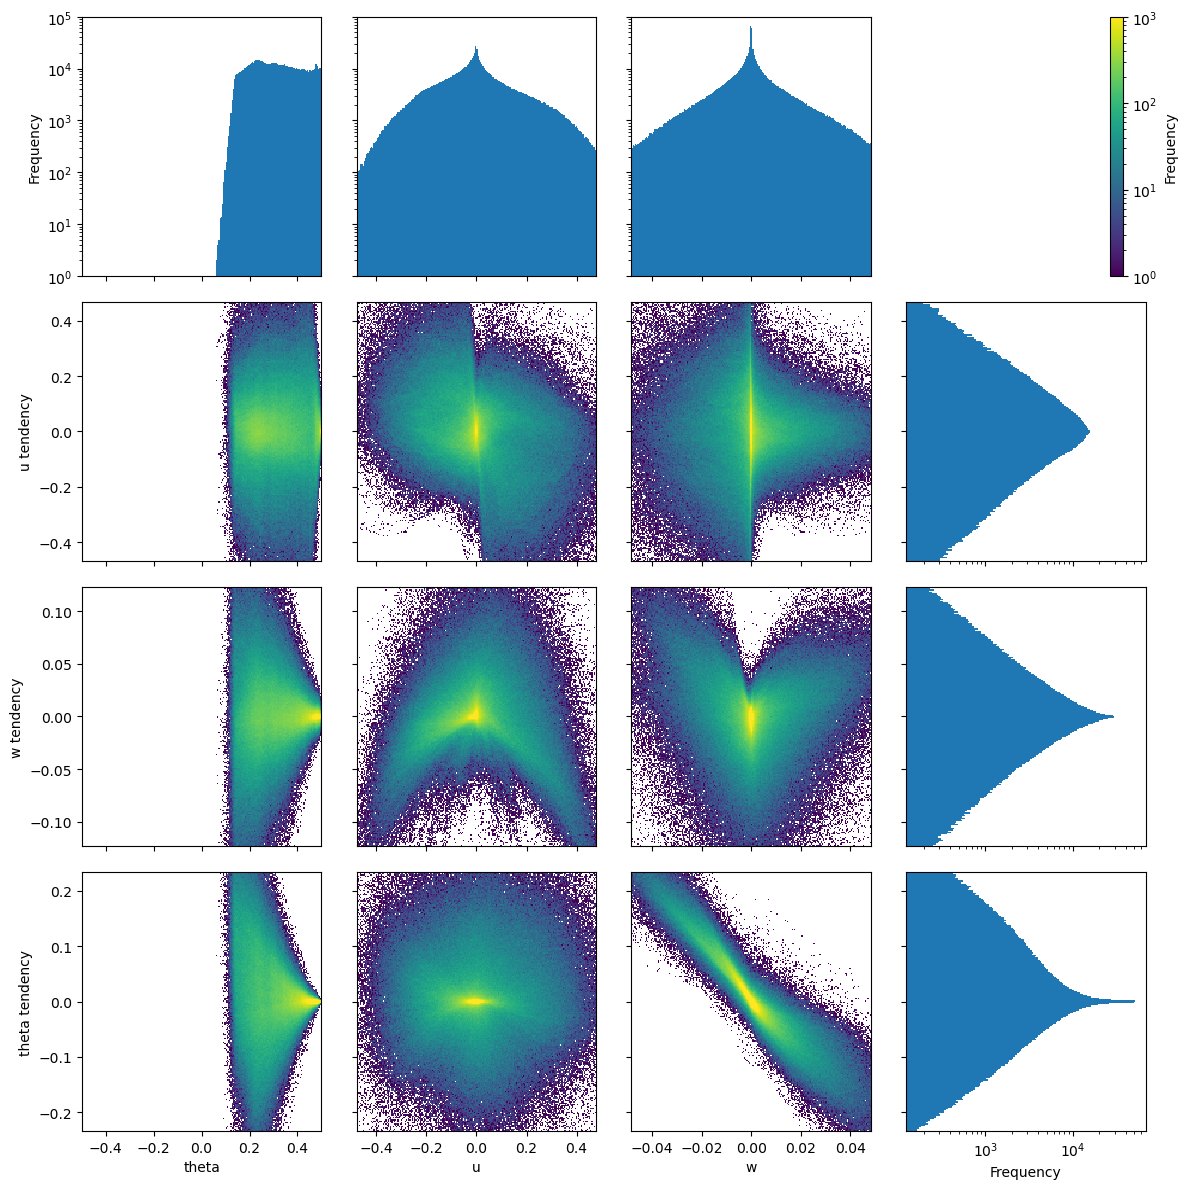

In [35]:
fig, axes = plt.subplots(4, 4, sharex='col', sharey='row', figsize=(12, 12))
hist1d_nbins = 200
hist2d_nbins = 200
n_std = 3

for i, tend_var in enumerate(subgrid_tend.data_vars):
    tend_data = param.sample(
        subgrid_tend[tend_var].compute(), x_sample, z_sample, 0, 0)
    tend_lim = n_std*tend_data.std()
    axes[i+1,0].set_ylabel(f'{tend_var} tendency')

    axes[i+1,3].hist(
        tend_data, bins=hist1d_nbins, orientation='horizontal',
        range=(-tend_lim, tend_lim), color='tab:blue',
        histtype='stepfilled', log=True
    )

    for j, state_var in enumerate(coarse_t.data_vars):
        state_data = param.sample(
            coarse_t[state_var].compute(), x_sample, z_sample,
            1/2 if state_var == 'theta' else 0,
            -1/2 if state_var == 'theta' else 0,
        )
        if state_var == 'theta':
            state_lim = 0.5
        else:
            state_lim = n_std*state_data.std()

        _, _, _, hist = axes[i+1,j].hist2d(
            state_data, tend_data, bins=[hist2d_nbins, hist2d_nbins],
            range=[[-state_lim, state_lim], [-tend_lim, tend_lim]],
            norm='log', vmin=1, vmax=1e3
        )

        if i == 0:
            axes[0,j].hist(
                state_data, bins=hist1d_nbins,
                range=(-state_lim, state_lim), color='tab:blue',
                histtype='stepfilled', log=True
            )
            axes[0,j].set_ylim(1, 1e5)
            axes[-1,j].set_xlabel(state_var)

fig.colorbar(hist, ax=axes[0,-1], label='Frequency')
axes[0,0].set_ylabel('Frequency')
axes[-1,-1].set_xlabel('Frequency')
axes[0,3].remove()
fig.tight_layout()

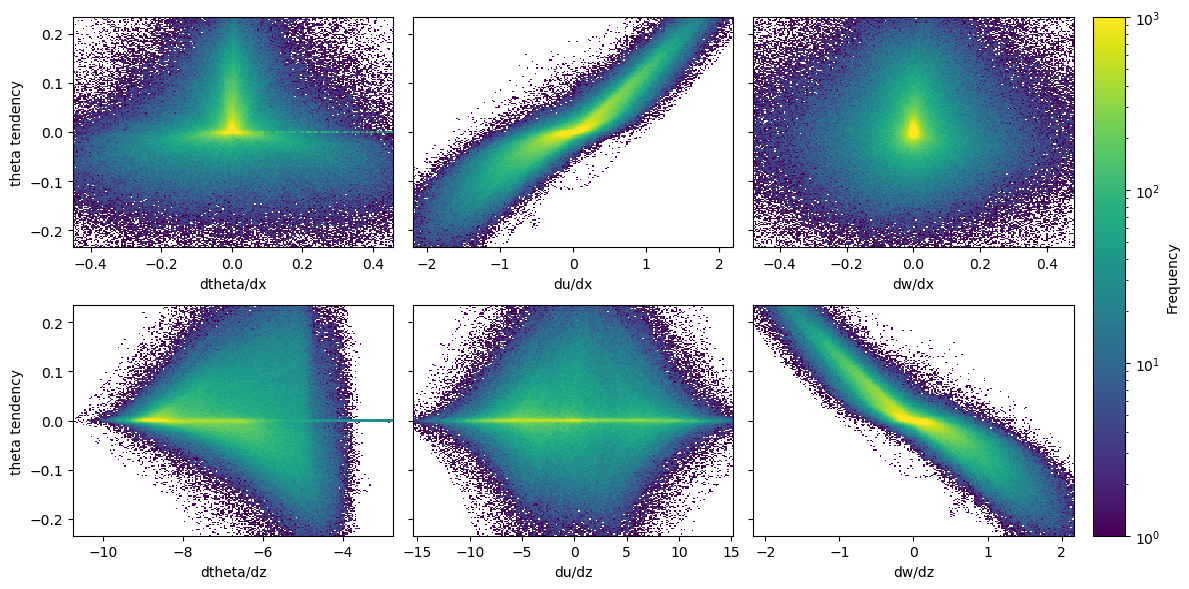

In [64]:
fig = plt.figure(figsize=(12, 6))
gs = mpl.gridspec.GridSpec(
    2, 4, height_ratios=[1, 1], width_ratios=[1, 1, 1, 0.1])
hist2d_nbins = 200
n_std = 3

tend_var = 'theta'
tend_data = param.sample(
    subgrid_tend[tend_var].compute(), x_sample, z_sample, 0, 0)
tend_lim = n_std*tend_data.std()

for i, coord in enumerate(['x', 'z']):
    for j, state_var in enumerate(coarse_t.data_vars):
        state_data = param.sample(
            coarse_t[state_var].differentiate(coord).compute(),
            x_sample, z_sample,
            1/2 if state_var == 'theta' else 0,
            -1/2 if state_var == 'theta' else 0,
        )
        state_lim = n_std*state_data.std()
        state_mean = state_data.mean()

        ax = fig.add_subplot(gs[i,j])
        _, _, _, hist = ax.hist2d(
            state_data, tend_data, bins=[hist2d_nbins, hist2d_nbins],
            range=[
                [state_mean - state_lim, state_mean + state_lim],
                [-tend_lim, tend_lim],
            ],
            norm='log', vmin=1, vmax=1e3,
        )

        ax.set_xlabel(f'd{state_var}/d{coord}')
        if j == 0:
            ax.set_ylabel(f'{tend_var} tendency')
        else:
            ax.set_yticklabels([])

ax = fig.add_subplot(gs[:,-1])
fig.colorbar(hist, cax=ax, label='Frequency')
fig.tight_layout()

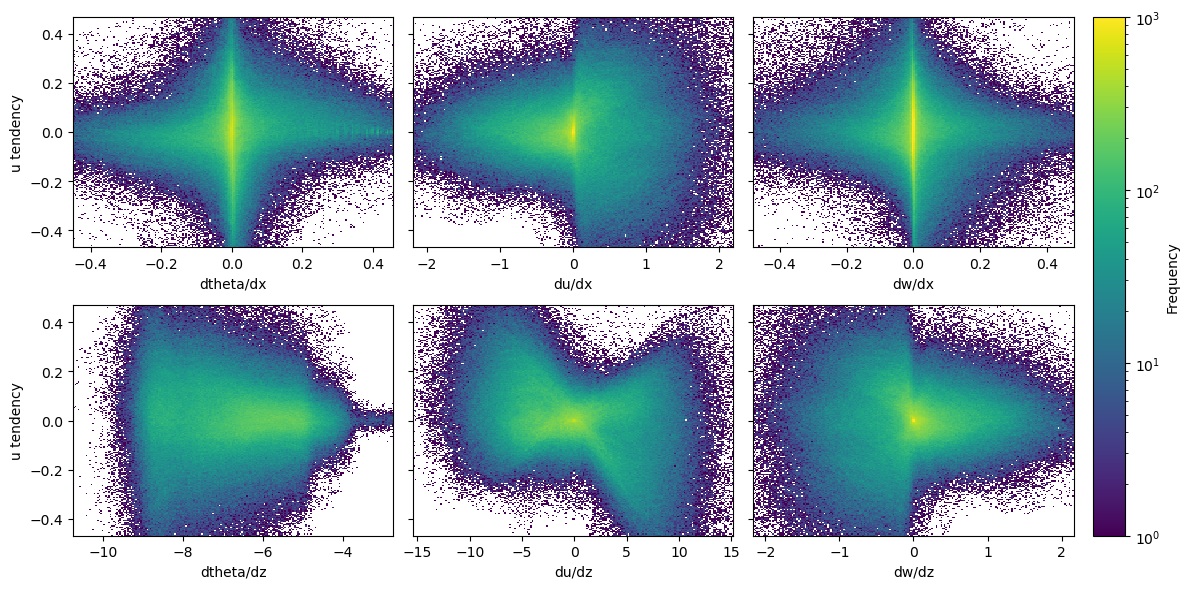

In [66]:
fig = plt.figure(figsize=(12, 6))
gs = mpl.gridspec.GridSpec(
    2, 4, height_ratios=[1, 1], width_ratios=[1, 1, 1, 0.1])
hist2d_nbins = 200
n_std = 3

tend_var = 'u'
tend_data = param.sample(
    subgrid_tend[tend_var].compute(), x_sample, z_sample, 0, 0)
tend_lim = n_std*tend_data.std()

for i, coord in enumerate(['x', 'z']):
    for j, state_var in enumerate(coarse_t.data_vars):
        state_data = param.sample(
            coarse_t[state_var].differentiate(coord).compute(),
            x_sample, z_sample,
            1/2 if state_var == 'theta' else 0,
            -1/2 if state_var == 'theta' else 0,
        )
        state_lim = n_std*state_data.std()
        state_mean = state_data.mean()

        ax = fig.add_subplot(gs[i,j])
        _, _, _, hist = ax.hist2d(
            state_data, tend_data, bins=[hist2d_nbins, hist2d_nbins],
            range=[
                [state_mean - state_lim, state_mean + state_lim],
                [-tend_lim, tend_lim],
            ],
            norm='log', vmin=1, vmax=1e3,
        )

        ax.set_xlabel(f'd{state_var}/d{coord}')
        if j == 0:
            ax.set_ylabel(f'{tend_var} tendency')
        else:
            ax.set_yticklabels([])

ax = fig.add_subplot(gs[:,-1])
fig.colorbar(hist, cax=ax, label='Frequency')
fig.tight_layout()

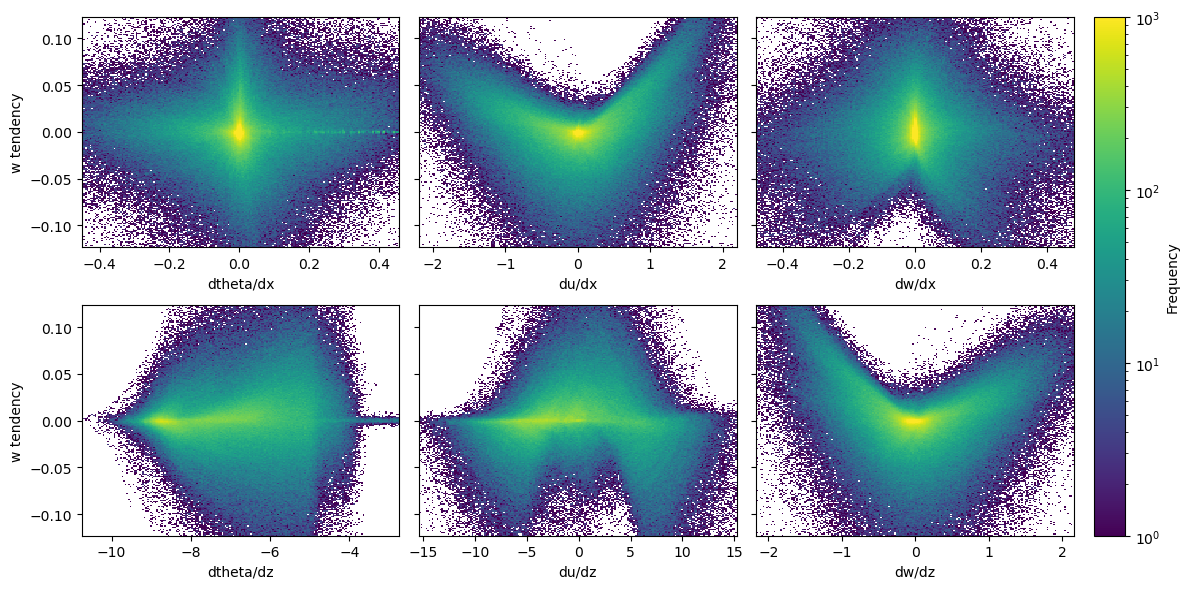

In [68]:
fig = plt.figure(figsize=(12, 6))
gs = mpl.gridspec.GridSpec(
    2, 4, height_ratios=[1, 1], width_ratios=[1, 1, 1, 0.1])
hist2d_nbins = 200
n_std = 3

tend_var = 'w'
tend_data = param.sample(
    subgrid_tend[tend_var].compute(), x_sample, z_sample, 0, 0)
tend_lim = n_std*tend_data.std()

for i, coord in enumerate(['x', 'z']):
    for j, state_var in enumerate(coarse_t.data_vars):
        state_data = param.sample(
            coarse_t[state_var].differentiate(coord).compute(),
            x_sample, z_sample,
            1/2 if state_var == 'theta' else 0,
            -1/2 if state_var == 'theta' else 0,
        )
        state_lim = n_std*state_data.std()
        state_mean = state_data.mean()

        ax = fig.add_subplot(gs[i,j])
        _, _, _, hist = ax.hist2d(
            state_data, tend_data, bins=[hist2d_nbins, hist2d_nbins],
            range=[
                [state_mean - state_lim, state_mean + state_lim],
                [-tend_lim, tend_lim],
            ],
            norm='log', vmin=1, vmax=1e3,
        )

        ax.set_xlabel(f'd{state_var}/d{coord}')
        if j == 0:
            ax.set_ylabel(f'{tend_var} tendency')
        else:
            ax.set_yticklabels([])

ax = fig.add_subplot(gs[:,-1])
fig.colorbar(hist, cax=ax, label='Frequency')
fig.tight_layout()

### $0.95 \leq z \leq 1$

In [39]:
rng = np.random.default_rng(seed=0)
x_sample = rng.uniform(0, 8, 256*32)
z_sample = rng.uniform(0.95, 1, 256*32)

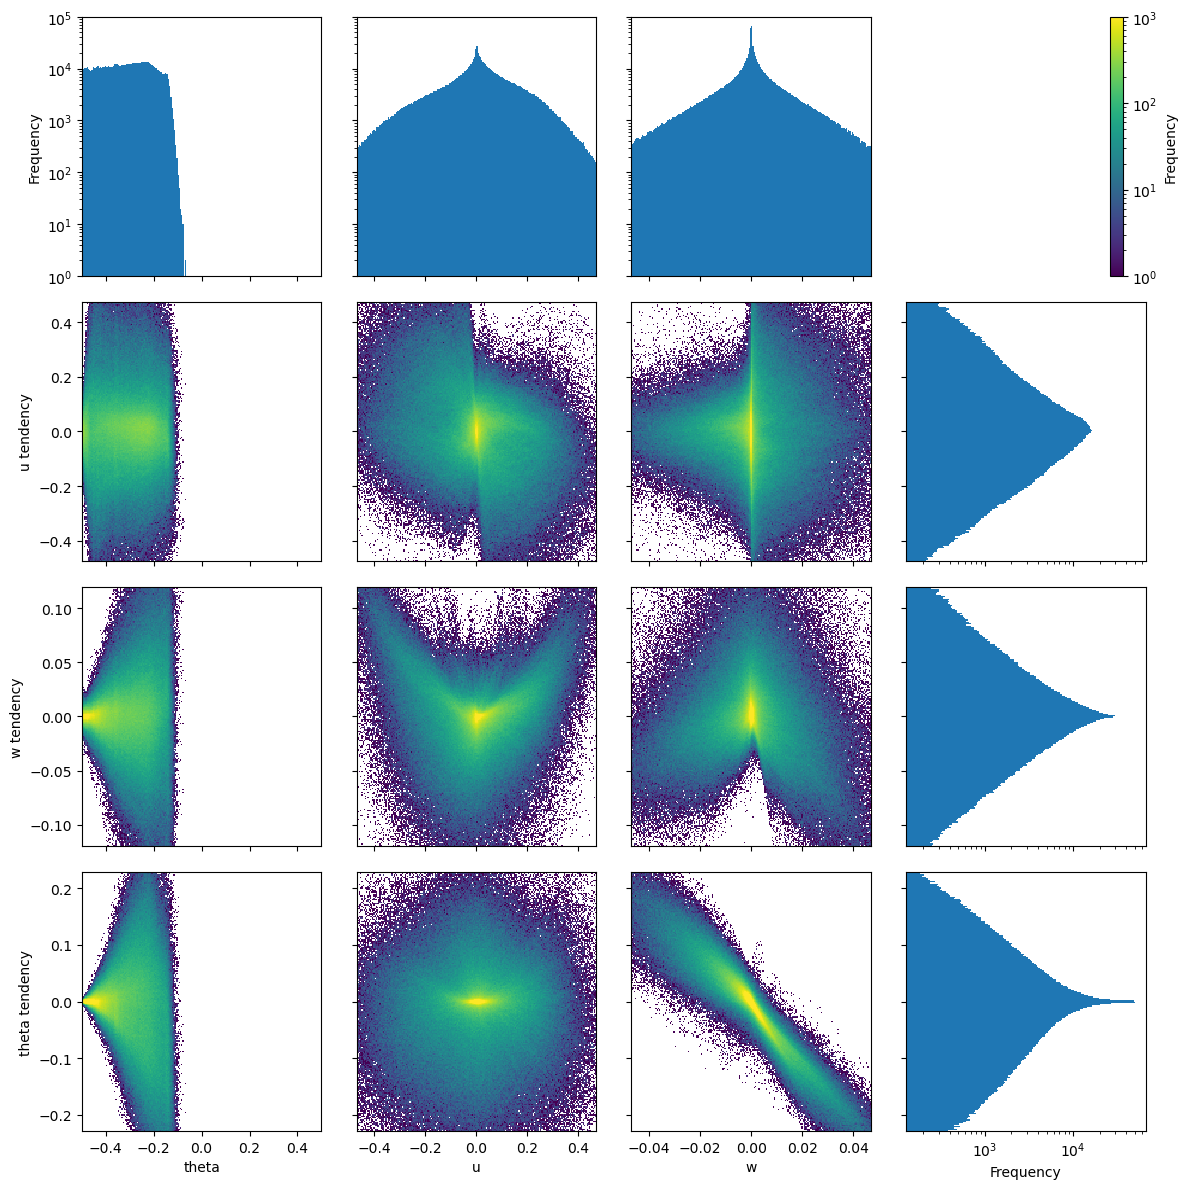

In [42]:
fig, axes = plt.subplots(4, 4, sharex='col', sharey='row', figsize=(12, 12))
hist1d_nbins = 200
hist2d_nbins = 200
n_std = 3

for i, tend_var in enumerate(subgrid_tend.data_vars):
    tend_data = param.sample(
        subgrid_tend[tend_var].compute(), x_sample, z_sample, 0, 0)
    tend_lim = n_std*tend_data.std()
    axes[i+1,0].set_ylabel(f'{tend_var} tendency')

    axes[i+1,3].hist(
        tend_data, bins=hist1d_nbins, orientation='horizontal',
        range=(-tend_lim, tend_lim), color='tab:blue',
        histtype='stepfilled', log=True
    )

    for j, state_var in enumerate(coarse_t.data_vars):
        state_data = param.sample(
            coarse_t[state_var].compute(), x_sample, z_sample,
            1/2 if state_var == 'theta' else 0,
            -1/2 if state_var == 'theta' else 0,
        )
        if state_var == 'theta':
            state_lim = 0.5
        else:
            state_lim = n_std*state_data.std()

        _, _, _, hist = axes[i+1,j].hist2d(
            state_data, tend_data, bins=[hist2d_nbins, hist2d_nbins],
            range=[[-state_lim, state_lim], [-tend_lim, tend_lim]],
            norm='log', vmin=1, vmax=1e3
        )

        if i == 0:
            axes[0,j].hist(
                state_data, bins=hist1d_nbins,
                range=(-state_lim, state_lim), color='tab:blue',
                histtype='stepfilled', log=True
            )
            axes[0,j].set_ylim(1, 1e5)
            axes[-1,j].set_xlabel(state_var)

fig.colorbar(hist, ax=axes[0,-1], label='Frequency')
axes[0,0].set_ylabel('Frequency')
axes[-1,-1].set_xlabel('Frequency')
axes[0,3].remove()
fig.tight_layout()

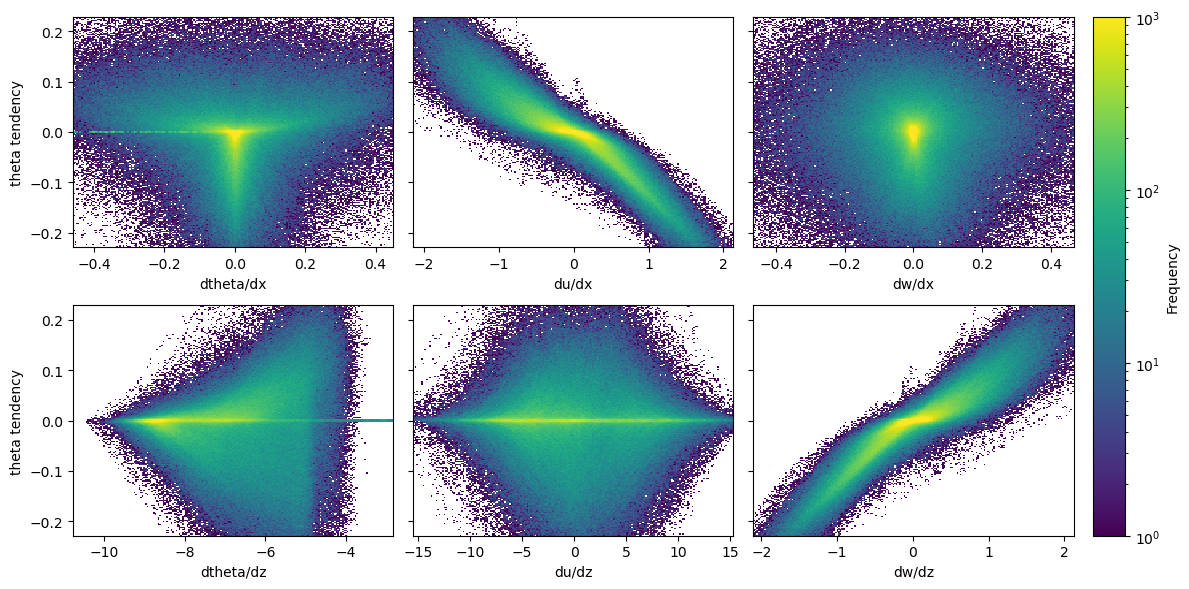

In [43]:
fig = plt.figure(figsize=(12, 6))
gs = mpl.gridspec.GridSpec(
    2, 4, height_ratios=[1, 1], width_ratios=[1, 1, 1, 0.1])
hist2d_nbins = 200
n_std = 3

tend_var = 'theta'
tend_data = param.sample(
    subgrid_tend[tend_var].compute(), x_sample, z_sample, 0, 0)
tend_lim = n_std*tend_data.std()

for i, coord in enumerate(['x', 'z']):
    for j, state_var in enumerate(coarse_t.data_vars):
        state_data = param.sample(
            coarse_t[state_var].differentiate(coord).compute(),
            x_sample, z_sample,
            1/2 if state_var == 'theta' else 0,
            -1/2 if state_var == 'theta' else 0,
        )
        state_lim = n_std*state_data.std()
        state_mean = state_data.mean()

        ax = fig.add_subplot(gs[i,j])
        _, _, _, hist = ax.hist2d(
            state_data, tend_data, bins=[hist2d_nbins, hist2d_nbins],
            range=[
                [state_mean - state_lim, state_mean + state_lim],
                [-tend_lim, tend_lim],
            ],
            norm='log', vmin=1, vmax=1e3,
        )

        ax.set_xlabel(f'd{state_var}/d{coord}')
        if j == 0:
            ax.set_ylabel(f'{tend_var} tendency')
        else:
            ax.set_yticklabels([])

ax = fig.add_subplot(gs[:,-1])
fig.colorbar(hist, cax=ax, label='Frequency')
fig.tight_layout()

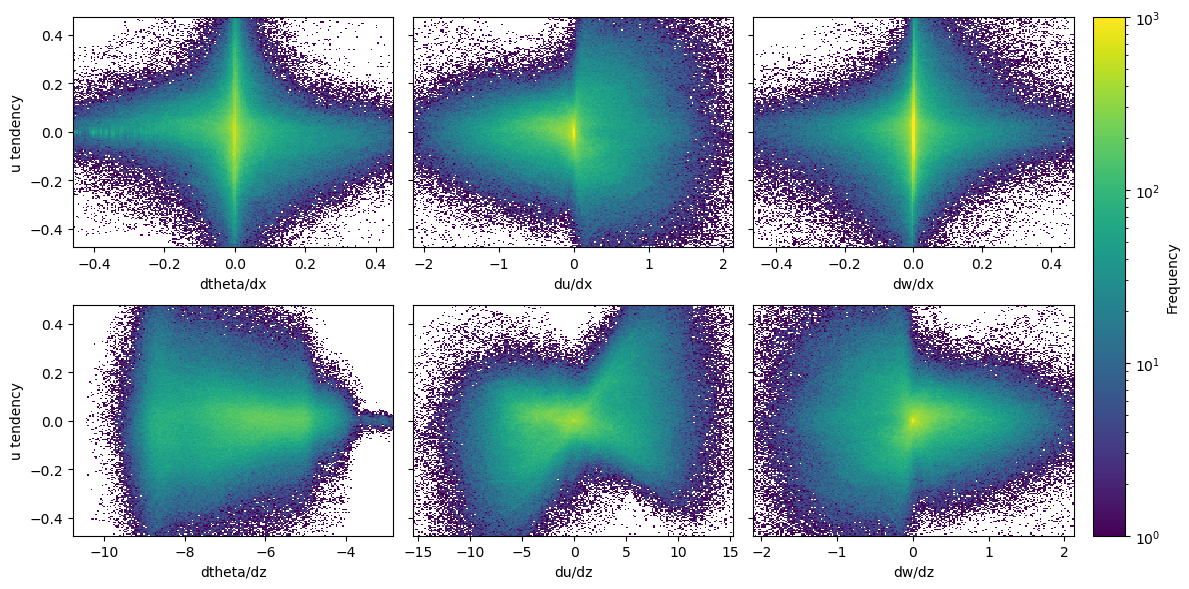

In [44]:
fig = plt.figure(figsize=(12, 6))
gs = mpl.gridspec.GridSpec(
    2, 4, height_ratios=[1, 1], width_ratios=[1, 1, 1, 0.1])
hist2d_nbins = 200
n_std = 3

tend_var = 'u'
tend_data = param.sample(
    subgrid_tend[tend_var].compute(), x_sample, z_sample, 0, 0)
tend_lim = n_std*tend_data.std()

for i, coord in enumerate(['x', 'z']):
    for j, state_var in enumerate(coarse_t.data_vars):
        state_data = param.sample(
            coarse_t[state_var].differentiate(coord).compute(),
            x_sample, z_sample,
            1/2 if state_var == 'theta' else 0,
            -1/2 if state_var == 'theta' else 0,
        )
        state_lim = n_std*state_data.std()
        state_mean = state_data.mean()

        ax = fig.add_subplot(gs[i,j])
        _, _, _, hist = ax.hist2d(
            state_data, tend_data, bins=[hist2d_nbins, hist2d_nbins],
            range=[
                [state_mean - state_lim, state_mean + state_lim],
                [-tend_lim, tend_lim],
            ],
            norm='log', vmin=1, vmax=1e3,
        )

        ax.set_xlabel(f'd{state_var}/d{coord}')
        if j == 0:
            ax.set_ylabel(f'{tend_var} tendency')
        else:
            ax.set_yticklabels([])

ax = fig.add_subplot(gs[:,-1])
fig.colorbar(hist, cax=ax, label='Frequency')
fig.tight_layout()

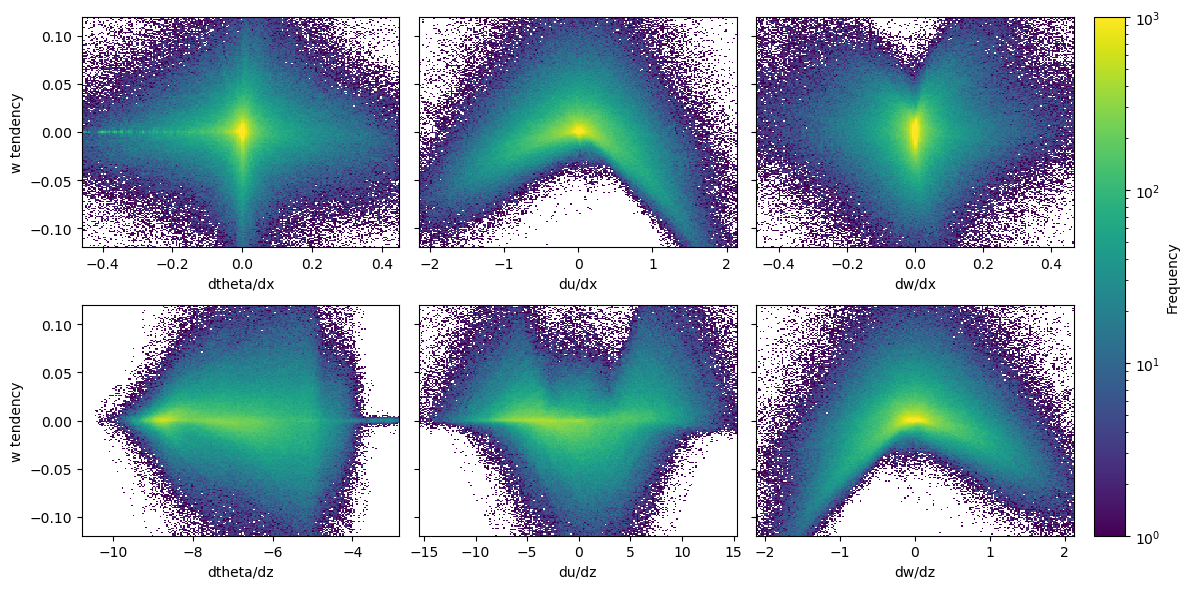

In [45]:
fig = plt.figure(figsize=(12, 6))
gs = mpl.gridspec.GridSpec(
    2, 4, height_ratios=[1, 1], width_ratios=[1, 1, 1, 0.1])
hist2d_nbins = 200
n_std = 3

tend_var = 'w'
tend_data = param.sample(
    subgrid_tend[tend_var].compute(), x_sample, z_sample, 0, 0)
tend_lim = n_std*tend_data.std()

for i, coord in enumerate(['x', 'z']):
    for j, state_var in enumerate(coarse_t.data_vars):
        state_data = param.sample(
            coarse_t[state_var].differentiate(coord).compute(),
            x_sample, z_sample,
            1/2 if state_var == 'theta' else 0,
            -1/2 if state_var == 'theta' else 0,
        )
        state_lim = n_std*state_data.std()
        state_mean = state_data.mean()

        ax = fig.add_subplot(gs[i,j])
        _, _, _, hist = ax.hist2d(
            state_data, tend_data, bins=[hist2d_nbins, hist2d_nbins],
            range=[
                [state_mean - state_lim, state_mean + state_lim],
                [-tend_lim, tend_lim],
            ],
            norm='log', vmin=1, vmax=1e3,
        )

        ax.set_xlabel(f'd{state_var}/d{coord}')
        if j == 0:
            ax.set_ylabel(f'{tend_var} tendency')
        else:
            ax.set_yticklabels([])

ax = fig.add_subplot(gs[:,-1])
fig.colorbar(hist, cax=ax, label='Frequency')
fig.tight_layout()

### $0.25 \leq z \leq 0.75$

In [69]:
rng = np.random.default_rng(seed=0)
x_sample = rng.uniform(0, 8, 256*32)
z_sample = rng.uniform(0.25, 0.75, 256*32)

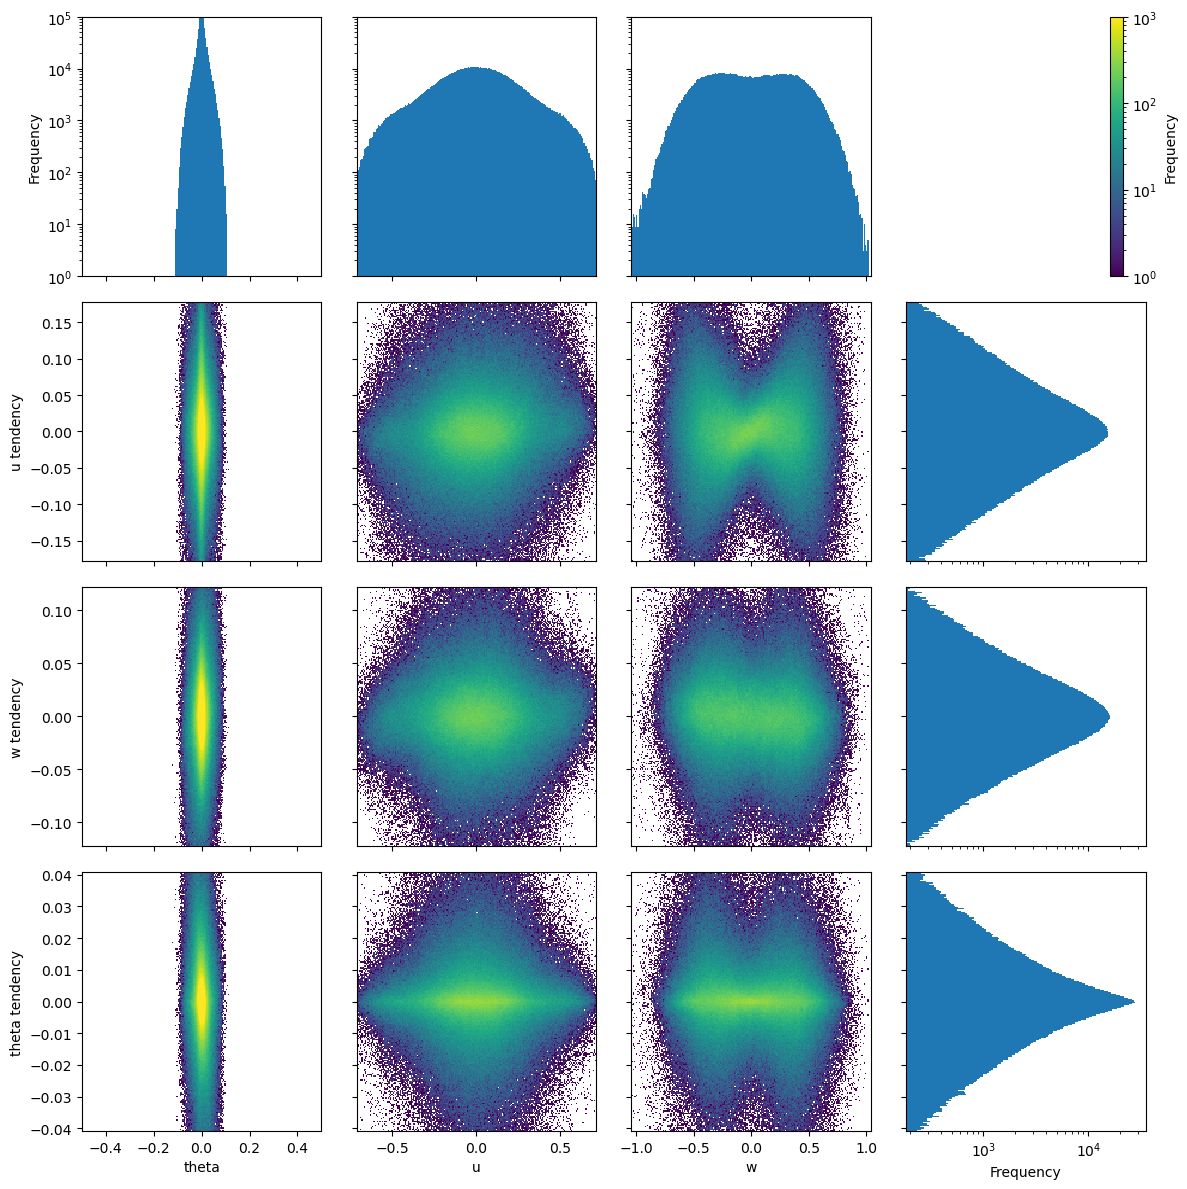

In [55]:
fig, axes = plt.subplots(4, 4, sharex='col', sharey='row', figsize=(12, 12))
hist1d_nbins = 200
hist2d_nbins = 200
n_std = 3

for i, tend_var in enumerate(subgrid_tend.data_vars):
    tend_data = param.sample(
        subgrid_tend[tend_var].compute(), x_sample, z_sample, 0, 0)
    tend_lim = n_std*tend_data.std()
    axes[i+1,0].set_ylabel(f'{tend_var} tendency')

    axes[i+1,3].hist(
        tend_data, bins=hist1d_nbins, orientation='horizontal',
        range=(-tend_lim, tend_lim), color='tab:blue',
        histtype='stepfilled', log=True
    )

    for j, state_var in enumerate(coarse_t.data_vars):
        state_data = param.sample(
            coarse_t[state_var].compute(), x_sample, z_sample,
            1/2 if state_var == 'theta' else 0,
            -1/2 if state_var == 'theta' else 0,
        )
        if state_var == 'theta':
            state_lim = 0.5
        else:
            state_lim = n_std*state_data.std()

        _, _, _, hist = axes[i+1,j].hist2d(
            state_data, tend_data, bins=[hist2d_nbins, hist2d_nbins],
            range=[[-state_lim, state_lim], [-tend_lim, tend_lim]],
            norm='log', vmin=1, vmax=1e3
        )

        if i == 0:
            axes[0,j].hist(
                state_data, bins=hist1d_nbins,
                range=(-state_lim, state_lim), color='tab:blue',
                histtype='stepfilled', log=True
            )
            axes[0,j].set_ylim(1, 1e5)
            axes[-1,j].set_xlabel(state_var)

fig.colorbar(hist, ax=axes[0,-1], label='Frequency')
axes[0,0].set_ylabel('Frequency')
axes[-1,-1].set_xlabel('Frequency')
axes[0,3].remove()
fig.tight_layout()

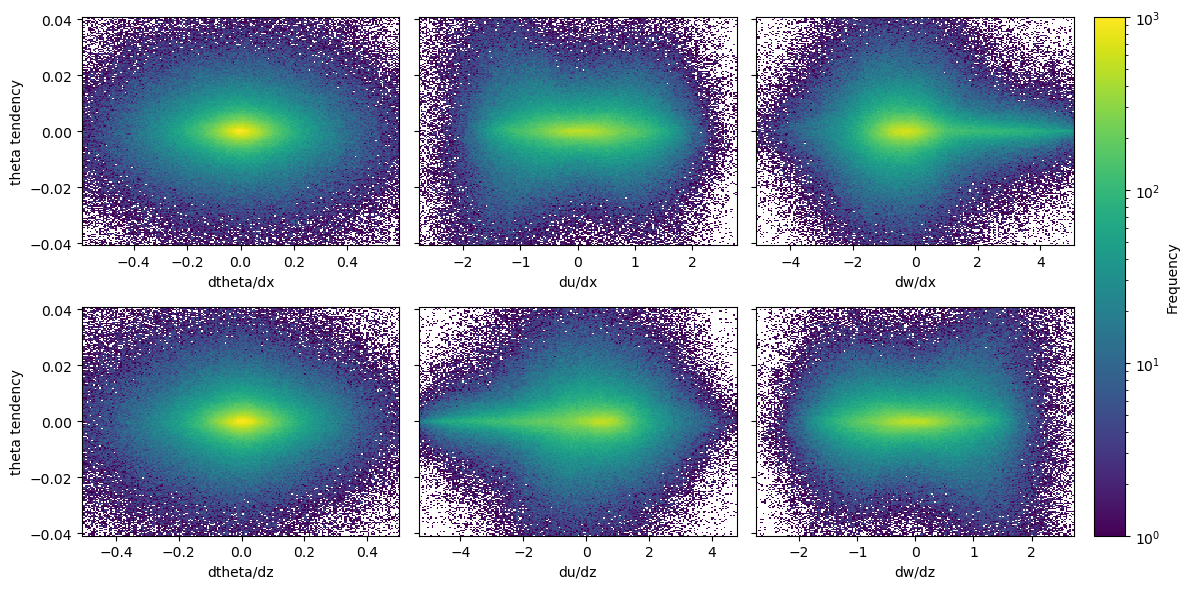

In [71]:
fig = plt.figure(figsize=(12, 6))
gs = mpl.gridspec.GridSpec(
    2, 4, height_ratios=[1, 1], width_ratios=[1, 1, 1, 0.1])
hist2d_nbins = 200
n_std = 3

tend_var = 'theta'
tend_data = param.sample(
    subgrid_tend[tend_var].compute(), x_sample, z_sample, 0, 0)
tend_lim = n_std*tend_data.std()

for i, coord in enumerate(['x', 'z']):
    for j, state_var in enumerate(coarse_t.data_vars):
        state_data = param.sample(
            coarse_t[state_var].differentiate(coord).compute(),
            x_sample, z_sample,
            1/2 if state_var == 'theta' else 0,
            -1/2 if state_var == 'theta' else 0,
        )
        state_lim = n_std*state_data.std()
        state_mean = state_data.mean()

        ax = fig.add_subplot(gs[i,j])
        _, _, _, hist = ax.hist2d(
            state_data, tend_data, bins=[hist2d_nbins, hist2d_nbins],
            range=[
                [state_mean - state_lim, state_mean + state_lim],
                [-tend_lim, tend_lim],
            ],
            norm='log', vmin=1, vmax=1e3,
        )

        ax.set_xlabel(f'd{state_var}/d{coord}')
        if j == 0:
            ax.set_ylabel(f'{tend_var} tendency')
        else:
            ax.set_yticklabels([])

ax = fig.add_subplot(gs[:,-1])
fig.colorbar(hist, cax=ax, label='Frequency')
fig.tight_layout()

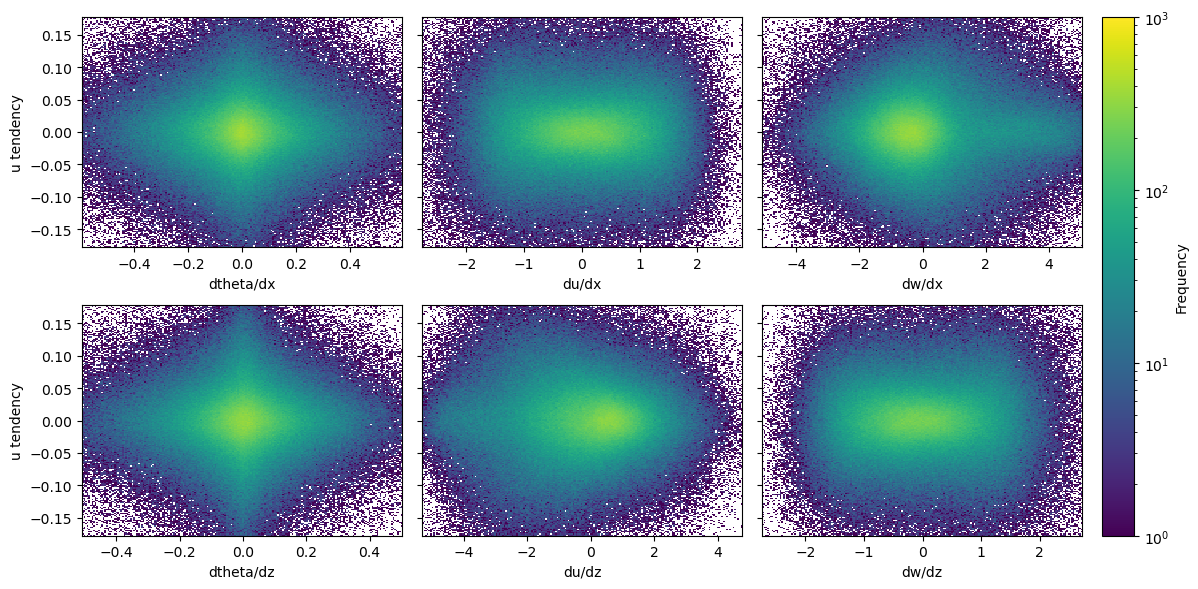

In [73]:
fig = plt.figure(figsize=(12, 6))
gs = mpl.gridspec.GridSpec(
    2, 4, height_ratios=[1, 1], width_ratios=[1, 1, 1, 0.1])
hist2d_nbins = 200
n_std = 3

tend_var = 'u'
tend_data = param.sample(
    subgrid_tend[tend_var].compute(), x_sample, z_sample, 0, 0)
tend_lim = n_std*tend_data.std()

for i, coord in enumerate(['x', 'z']):
    for j, state_var in enumerate(coarse_t.data_vars):
        state_data = param.sample(
            coarse_t[state_var].differentiate(coord).compute(),
            x_sample, z_sample,
            1/2 if state_var == 'theta' else 0,
            -1/2 if state_var == 'theta' else 0,
        )
        state_lim = n_std*state_data.std()
        state_mean = state_data.mean()

        ax = fig.add_subplot(gs[i,j])
        _, _, _, hist = ax.hist2d(
            state_data, tend_data, bins=[hist2d_nbins, hist2d_nbins],
            range=[
                [state_mean - state_lim, state_mean + state_lim],
                [-tend_lim, tend_lim],
            ],
            norm='log', vmin=1, vmax=1e3,
        )

        ax.set_xlabel(f'd{state_var}/d{coord}')
        if j == 0:
            ax.set_ylabel(f'{tend_var} tendency')
        else:
            ax.set_yticklabels([])

ax = fig.add_subplot(gs[:,-1])
fig.colorbar(hist, cax=ax, label='Frequency')
fig.tight_layout()

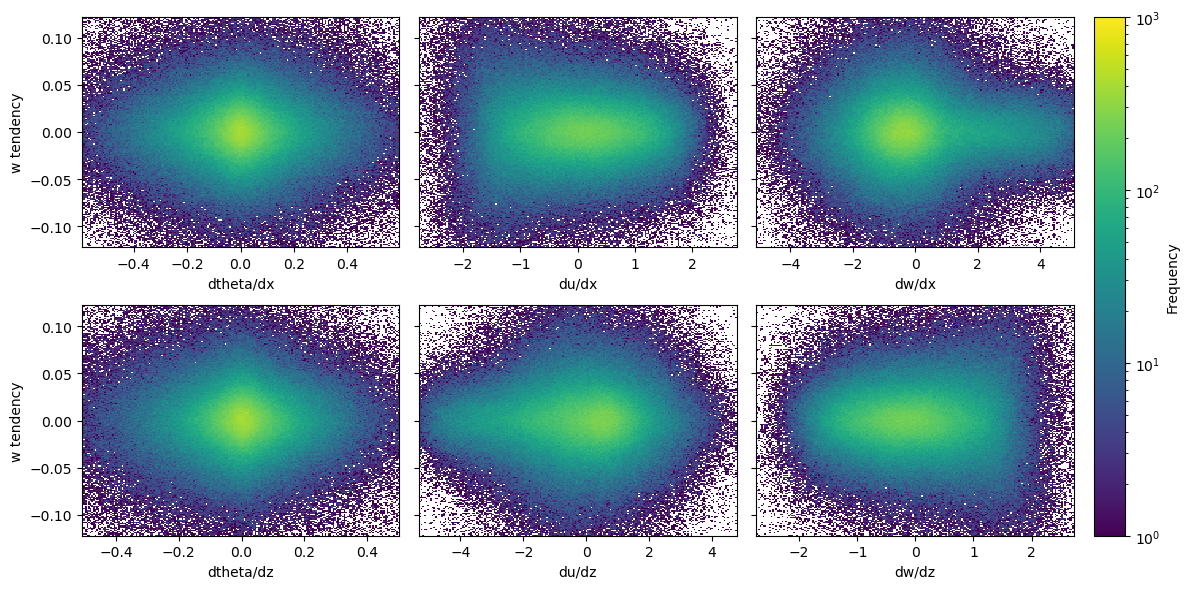

In [75]:
fig = plt.figure(figsize=(12, 6))
gs = mpl.gridspec.GridSpec(
    2, 4, height_ratios=[1, 1], width_ratios=[1, 1, 1, 0.1])
hist2d_nbins = 200
n_std = 3

tend_var = 'w'
tend_data = param.sample(
    subgrid_tend[tend_var].compute(), x_sample, z_sample, 0, 0)
tend_lim = n_std*tend_data.std()

for i, coord in enumerate(['x', 'z']):
    for j, state_var in enumerate(coarse_t.data_vars):
        state_data = param.sample(
            coarse_t[state_var].differentiate(coord).compute(),
            x_sample, z_sample,
            1/2 if state_var == 'theta' else 0,
            -1/2 if state_var == 'theta' else 0,
        )
        state_lim = n_std*state_data.std()
        state_mean = state_data.mean()

        ax = fig.add_subplot(gs[i,j])
        _, _, _, hist = ax.hist2d(
            state_data, tend_data, bins=[hist2d_nbins, hist2d_nbins],
            range=[
                [state_mean - state_lim, state_mean + state_lim],
                [-tend_lim, tend_lim],
            ],
            norm='log', vmin=1, vmax=1e3,
        )

        ax.set_xlabel(f'd{state_var}/d{coord}')
        if j == 0:
            ax.set_ylabel(f'{tend_var} tendency')
        else:
            ax.set_yticklabels([])

ax = fig.add_subplot(gs[:,-1])
fig.colorbar(hist, cax=ax, label='Frequency')
fig.tight_layout()

### Observations
- Strong negative correlation between $w$ and $\theta$ tendency in both boundary layers
- Strong correlation between $du/dx = -dw/dz$ and $\theta$ tendency in boundary layers, but sign is different between bottom and top

## Subgrid tendency vs. resolved tendency

### Whole domain

In [76]:
rng = np.random.default_rng(seed=0)
x_sample = rng.uniform(0, 8, 256*32)
z_sample = rng.uniform(0, 1, 256*32)

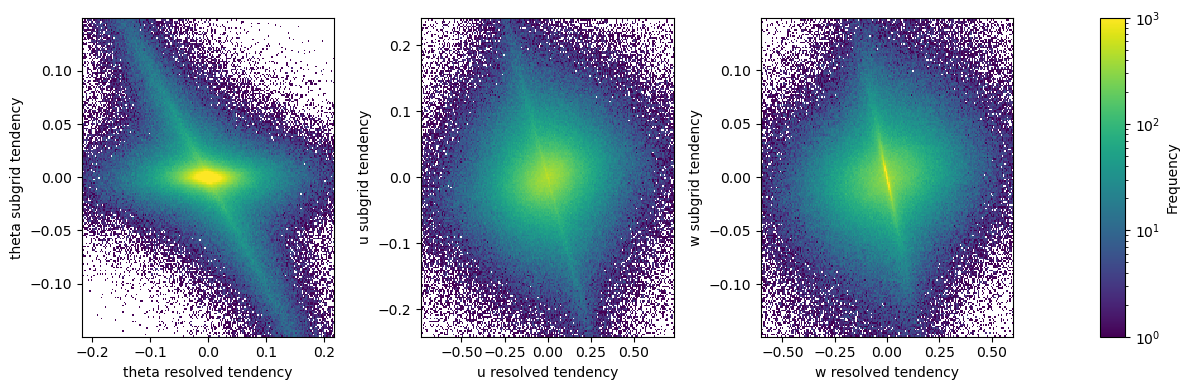

In [78]:
fig = plt.figure(figsize=(12, 4))
gs = mpl.gridspec.GridSpec(
    1, 4, height_ratios=[1], width_ratios=[1, 1, 1, 0.1])
hist2d_nbins = 200
n_std = 3

for i, var in enumerate(coarse_t.data_vars):
    sub_tend_data = param.sample(
        subgrid_tend[var].compute(), x_sample, z_sample, 0, 0)
    sub_tend_lim = n_std*sub_tend_data.std()
    
    res_tend_data = param.sample(
        coarse_tend[var].compute(), x_sample, z_sample, 0, 0)
    res_tend_lim = n_std*res_tend_data.std()

    ax = fig.add_subplot(gs[i])
    _, _, _, hist = ax.hist2d(
        res_tend_data, sub_tend_data, bins=[hist2d_nbins, hist2d_nbins],
        range=[
            [-res_tend_lim, res_tend_lim],
            [-sub_tend_lim, sub_tend_lim],
        ],
        norm='log', vmin=1, vmax=1e3,
    )

    ax.set(xlabel=f'{var} resolved tendency', ylabel=f'{var} subgrid tendency')

ax = fig.add_subplot(gs[:,-1])
fig.colorbar(hist, cax=ax, label='Frequency')
fig.tight_layout()

### $0 \leq z \leq 0.05$ or $0.95 \leq z \leq 1$

In [83]:
rng = np.random.default_rng(seed=0)
x_sample = rng.uniform(0, 8, 256*32)
z_sample = np.concatenate([
    rng.uniform(0, 0.05, 256*32//2), rng.uniform(0.95, 1, 256*32//2)
])

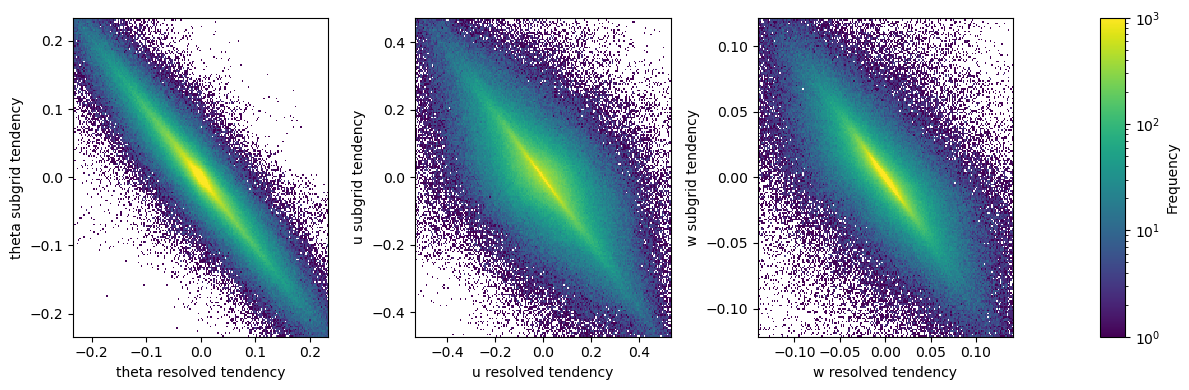

In [84]:
fig = plt.figure(figsize=(12, 4))
gs = mpl.gridspec.GridSpec(
    1, 4, height_ratios=[1], width_ratios=[1, 1, 1, 0.1])
hist2d_nbins = 200
n_std = 3

for i, var in enumerate(coarse_t.data_vars):
    sub_tend_data = param.sample(
        subgrid_tend[var].compute(), x_sample, z_sample, 0, 0)
    sub_tend_lim = n_std*sub_tend_data.std()
    
    res_tend_data = param.sample(
        coarse_tend[var].compute(), x_sample, z_sample, 0, 0)
    res_tend_lim = n_std*res_tend_data.std()

    ax = fig.add_subplot(gs[i])
    _, _, _, hist = ax.hist2d(
        res_tend_data, sub_tend_data, bins=[hist2d_nbins, hist2d_nbins],
        range=[
            [-res_tend_lim, res_tend_lim],
            [-sub_tend_lim, sub_tend_lim],
        ],
        norm='log', vmin=1, vmax=1e3,
    )

    ax.set(xlabel=f'{var} resolved tendency', ylabel=f'{var} subgrid tendency')

ax = fig.add_subplot(gs[:,-1])
fig.colorbar(hist, cax=ax, label='Frequency')
fig.tight_layout()

### $0.25 \leq z \leq 0.75$

In [85]:
rng = np.random.default_rng(seed=0)
x_sample = rng.uniform(0, 8, 256*32)
z_sample = rng.uniform(0.25, 0.75, 256*32)

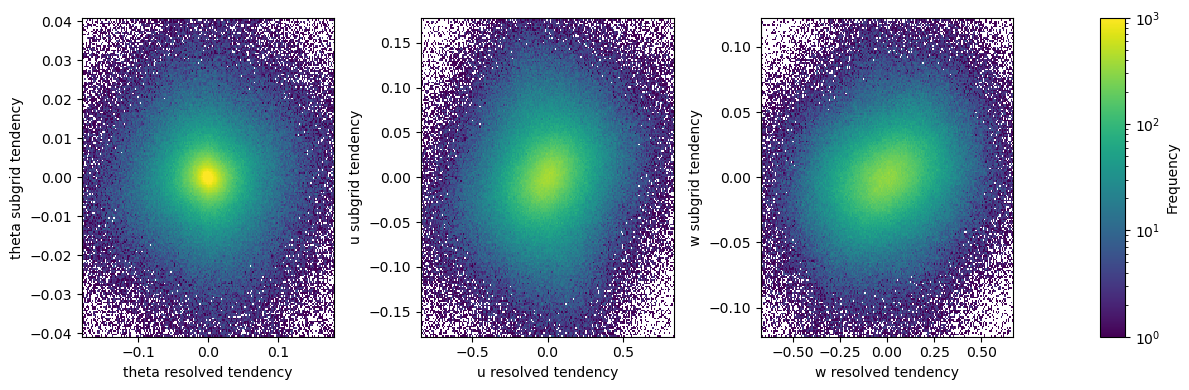

In [86]:
fig = plt.figure(figsize=(12, 4))
gs = mpl.gridspec.GridSpec(
    1, 4, height_ratios=[1], width_ratios=[1, 1, 1, 0.1])
hist2d_nbins = 200
n_std = 3

for i, var in enumerate(coarse_t.data_vars):
    sub_tend_data = param.sample(
        subgrid_tend[var].compute(), x_sample, z_sample, 0, 0)
    sub_tend_lim = n_std*sub_tend_data.std()
    
    res_tend_data = param.sample(
        coarse_tend[var].compute(), x_sample, z_sample, 0, 0)
    res_tend_lim = n_std*res_tend_data.std()

    ax = fig.add_subplot(gs[i])
    _, _, _, hist = ax.hist2d(
        res_tend_data, sub_tend_data, bins=[hist2d_nbins, hist2d_nbins],
        range=[
            [-res_tend_lim, res_tend_lim],
            [-sub_tend_lim, sub_tend_lim],
        ],
        norm='log', vmin=1, vmax=1e3,
    )

    ax.set(xlabel=f'{var} resolved tendency', ylabel=f'{var} subgrid tendency')

ax = fig.add_subplot(gs[:,-1])
fig.colorbar(hist, cax=ax, label='Frequency')
fig.tight_layout()

## Time dependence of subgrid tendencies

In [95]:
fine_t = xr.open_mfdataset('../data/training/2048x256_hifreq_t/*.nc')
fine_tplusdt = xr.open_mfdataset('../data/training/2048x256_hifreq_tplusdt/*.nc')
fine_tend_filt = xr.open_dataset(
    '../data/training/2048x256_hifreq_tend_256x32/2048x256_hifreq_tend_256x32.nc')
coarse_t = xr.open_mfdataset(
    '../data/training/256x32_from_2048x256_hifreq_t/*.nc')
coarse_tplusdt = xr.open_mfdataset(
    '../data/training/256x32_from_2048x256_hifreq_tplusdt/*.nc')

fine_tend = param.tendency(fine_t, fine_tplusdt)
coarse_tend = param.tendency(coarse_t, coarse_tplusdt)
subgrid_tend = fine_tend_filt - coarse_tend

In [87]:
plt.rcParams.update({
    'animation.embed_limit': 1000,
    'animation.ffmpeg_path': (
        '/srv/ccrc/AtmSS/z5310829/miniconda3/envs/hons/bin/ffmpeg'
    )
})

In [128]:
fig = plt.figure(figsize=(12, 6))
gs = mpl.gridspec.GridSpec(
    3, 2, height_ratios=[1, 1, 1], width_ratios=[1, 0.02])

meshes = {}
for i, var in enumerate(subgrid_tend.data_vars):
    ax = fig.add_subplot(gs[i,0])
    meshes[var] = ax.pcolormesh(
        subgrid_tend.x, subgrid_tend.z, subgrid_tend[var].isel(t=0).T,
        cmap='RdBu_r', vmin=-0.4, vmax=0.4
    )
    # mesh.set_clim(-0.38, 0.38)
    ax.set(ylabel='$z$', aspect='equal', title=f'{var} subgrid tendency')
    if i == 2:
        ax.set_xlabel('$x$')
    else:
        ax.set_xticklabels([])

title = fig.suptitle('')
fig.colorbar(meshes['theta'], cax=fig.add_subplot(gs[:,1]))
fig.tight_layout()

def update(t):
    for var in subgrid_tend.data_vars:
        meshes[var].set_array(subgrid_tend[var].isel(t=t).T)
    title.set_text(f'$t$ = {subgrid_tend.t[t]:.3f}')
    return *meshes.values(), title

frames = range(0, subgrid_tend.t.size)
ani = FuncAnimation(
    fig, update, frames=frames, blit=True, interval=1e3/30)
plt.close()

ani.save('../data/training/2048x256_to_256x32_tend.mp4')

2023-10-03 17:56:25,449 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2023-10-03 17:56:25,450 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: /srv/ccrc/AtmSS/z5310829/miniconda3/envs/hons/bin/ffmpeg -f rawvideo -vcodec rawvideo -s 1200x600 -pix_fmt rgba -r 29.999999999999996 -i pipe: -vcodec h264 -pix_fmt yuv420p -y ../data/training/2048x256_to_256x32_tend.mp4


In [130]:
IPython.display.Video('../data/training/2048x256_to_256x32_tend.mp4')